# The Deutsch Jozsa Algorithm
- Identify whether a given function is constant or balanced!

In [21]:
#imports
from IPython.display import Latex
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, execute
from qiskit.circuit.library import *
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram, array_to_latex

backend = Aer.get_backend('qasm_simulator')

# Workshop contents
- Solving problems with Quantum Computers
- Deutsch-Jozsa Algorithm
- Run on real hardware


![](full-diagram.png "Solving Problems on Quantum Computers")

## Recap - Quantum Circuit Model

<img src='circuit-example.png' width=70%>

## The Quantum Algorithm - Deutsch-Jozsa

- Only need to run f(x) once to know if constant or balanced. O(1)
- Published in 1992, first example of a quantum algorithm that performs better than the best classical algorithm.





![](diagram-3.png)

## Step 1 - Prepare the initial circuit
<img src='step-0.png' width=60%>


<img src='step-1.png' width=60%>


In [31]:
N = 3

In [32]:
dj_circuit = QuantumCircuit(N + 1)

In [33]:
# just add an X gate on the circuit 
def build_init_state(n, circuit):
    # step 1
    circuit.x(n)
    circuit.barrier()
    
    # step 2
    circuit.h(n)
    circuit.h(range(n))

In [34]:
build_init_state(N, dj_circuit)

#### Draw

In [28]:
dj_circuit.h(range(N))

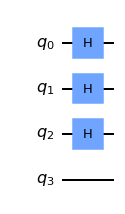

In [29]:
dj_circuit.draw('mpl')

In [30]:
dj_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘
q_3: ─────

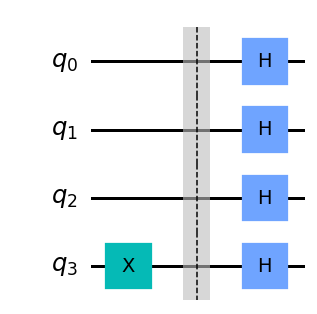

In [35]:
dj_circuit.draw('mpl', scale = 1.5)

## Step 2 - Create a Deutsch-Jozsa Circuit Oracle
- As we studied in our lecture, we have the following requirement - 

<img src='step-2.png' width=60%>

### Constant Oracles 

- $\mathbf{f}(x) = 0$ then we have the state of the $|-\rangle$ qubit as **unchanged**, so we just use the $\mathbf{I}$ operator over it 
- In the other case, when $\mathbf{f}(x) = 1$ then we would have a *flip* over the phase of the extra qubit for each input $x$. This would mean we would apply just an $X$ gate to the $|-\rangle$ qubit

In [7]:
def get_constant_oracle(n):
    circuit = QuantumCircuit(n+1)
    circ_type = np.random.randint(0,2)
    print(f"Input bit size : {n}")
    print("Constant 0!") if circ_type == 0 else print("Constant 1!")
    if circ_type == 1:
        circuit.x(n)
    return circuit 

Input bit size : 3
Constant 1!


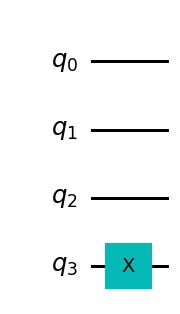

In [39]:
oracle = get_constant_oracle(N)
oracle.draw('mpl', scale = 1.5)

### Balanced Oracles

- For a balanced function, there are many different circuits we can create. One of the ways we can guarantee our circuit is balanced is by performing a CNOT for each qubit in register 1, with the qubit in register 2 as the target.

Example : 

<img src='3-cnot.svg' width=40%>

Here, the top 3 qubits form the input register, and the bottom qubit is the output register.
You can see from the table below that there are exactly **half** input states which output **0** and the other half output **1** 

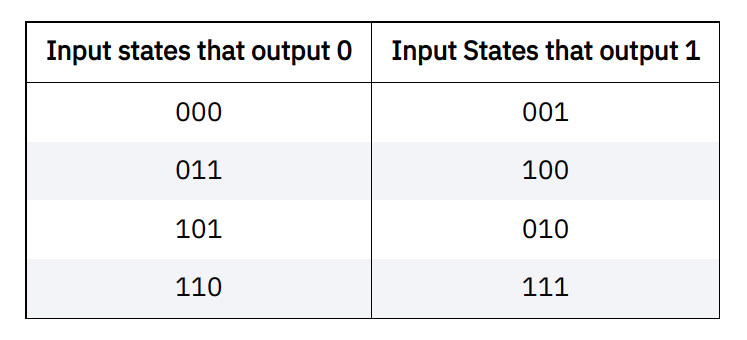

#### Why is this true? 

- This is because of the following fact - 
    $$^nC_0 + ^nC_2 + ^nC_4 + ... = ^nC_1 + ^nC_3 + ^nC_5 + ...$$


- Everyone knows the binomial expansion of $(1+x)^n = ^nC_0.x^0 + ^nC_1.x^1 + ^nC_2.x^2 + ... ^nC_n.x^n$
- If you put $x = -1$ here, you'll get the above result. Easy right? 

#### How does that help?

- Let us take an **n - bit** binary string 
- How many ways are there to place zero **1s** in the n places? $^nC_0$ 
- One **1**? $^nC_1$
- Two **1s**? $^nC_2$
- You get the point right! 

#### Can we get a balanced oracle?

- Now think of the basis states as these input bit strings 
- Each basis state which has **odd number of set 1s** will result in a **bit flip** on the $|-\rangle$ qubit and each basis state which has **even number of set 1s** (including 0) will result in **no bit flips** on $|-\rangle$ 
- How many basis states which have **odd number of set 1s** exist? 
    $$^nC_1 + ^nC_3 + ^nC_5 + ... = Odd$$
- For even? 
    $$^nC_0 + ^nC_2 + ^nC_4 + ... = Even$$ 
    
- We just proved that $Odd = Even$ in the above cell.
- Hence we have equal number of basis states with output as **1** and as **0**. 


#### Yes! Balanced Oracle!!!

- We can also have transformations like - 

<img src = 'one-x-3-cnot.svg' width=60%>

In [46]:
def get_balanced_oracle(n):
    print(f"Input bit size : {n}")
    print("Balanced!")
    
    oracle_qc = QuantumCircuit(n+1)
    
    # First generate a random number that tells us which CNOTs to
    # wrap in X-gates:
    b = np.random.randint(1,2**n)
    
    # Next, format 'b' as a binary string of length 'n', padded with zeros:
    b_str = format(b, '0'+str(n)+'b')
    print(b_str)
    
    # Next, we place the first X-gates. Each digit in our binary string 
    # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
    # we apply an X-gate to that qubit:
    for qubit in range(len(b_str)):
        if b_str[qubit] == '1':
            oracle_qc.x(qubit)
            
    
    # Do the controlled-NOT gates for each qubit, using the output qubit 
    # as the target:
    for qubit in range(n):
        oracle_qc.cx(qubit, n)
        
        
    # Next, place the final X-gates
    for qubit in range(len(b_str)):
        if b_str[qubit] == '1':
            oracle_qc.x(qubit)
            
            
    return oracle_qc

In [47]:
def test_balanced_oracle(n, oracle):
    print("Testing oracle!!")
    circ = QuantumCircuit(n+1, n+1)
  
    circ.h(range(n))
    circ.barrier()
    circ.compose(oracle, qubits = range(n+1), inplace = True)
    circ.barrier()
    
    circ.measure(range(n+1), range(n+1))
    display(circ.draw('mpl'))
    counts = execute(circ, backend, shots = 10000).result().get_counts()
    display(plot_histogram(counts))
    print(counts)

Input bit size : 3
Balanced!
101
Testing oracle!!


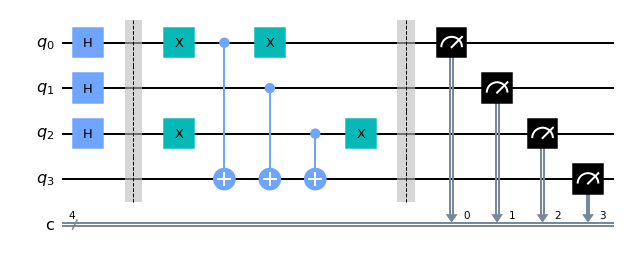

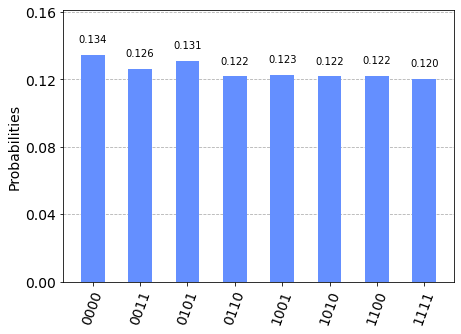

{'0101': 1310, '1100': 1220, '1001': 1227, '0110': 1218, '1111': 1203, '1010': 1218, '0000': 1344, '0011': 1260}


In [48]:
oracle = get_balanced_oracle(3)
test_balanced_oracle(3, oracle)

- Half the inputs output 0 and other half output 1!

In [43]:
def oracle_builder(n):
    oracle_type = np.random.randint(0,2)
    if oracle_type == 0:
        return "constant", get_constant_oracle(n)
    else:
        return "balanced", get_balanced_oracle(n)

## Step 3 - Create the Deutsch Jozsa Circuit
<img src="step-3.png" width=60%>

In [58]:
def build_dj_circuit(N, oracle):
    circuit = QuantumCircuit(N + 1, N )
    
    build_init_state(N ,circuit)
    
    circuit.barrier()
    
    #important
    circuit.compose(oracle, inplace = True)
    circuit.barrier()
    circuit.h(range(N))
    
    # important 
    circuit.measure(range(N), range(N))
    
    return circuit 

#### `compose` method

In [54]:
qc1 = QuantumCircuit(3)
qc2 = QuantumCircuit(2)

qc1.h(range(3))

qc2.x(range(2))
qc1.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

In [55]:
qc2.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘

In [56]:
qc1.compose(qc2, qubits = [1, 2], inplace = True)

In [57]:
qc1.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤┌───┐
q_1: ┤ H ├┤ X ├
     ├───┤├───┤
q_2: ┤ H ├┤ X ├
     └───┘└───┘

In [62]:
N = 3 
type_oracle, dj_oracle = oracle_builder(N)
dj_circuit = build_dj_circuit(N, dj_oracle)

Input bit size : 3
Balanced!
110


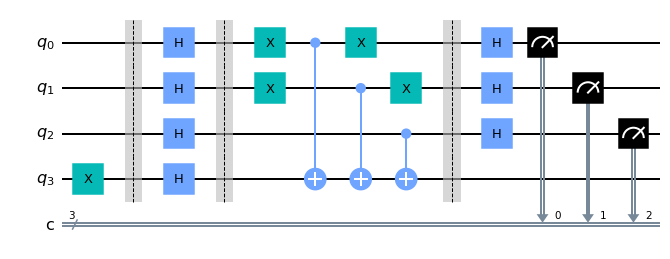

In [63]:
dj_circuit.draw('mpl')

## Step 4 - Run the circuit
- As expected, probability of $|0\rangle ^{\otimes n}$ should be - 
    - **1** if $\mathbf{f}(x)$ is *constant*
    - **0** if $\mathbf{f}(x)$ is *balanced*

{'111': 100}


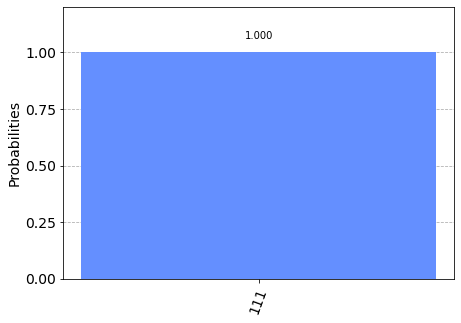

In [64]:
result = execute(dj_circuit, backend, shots = 100).result()
counts = result.get_counts()

print(counts)
plot_histogram(counts)

## Step 5 - Interpret Results
- The following block transforms our theoretical expectation into code!

In [66]:
counts

{'111': 100}

In [67]:
state = "0"*N 
print(state)
if type_oracle == "balanced":
    # their should be NO presence of the 00..0 state 
    if state not in counts:
        print("Correct!!")
    else:
        print("Wrong!!")
else:
    # only 00..0 should exist! 
    if state in counts and len(counts) == 1:
        print("Correct!!")
    else:
        print("Wrong!!")
    

000
Correct!!


## Stress Test!

In [68]:
correct = 0 
incorrect = 0 

for _ in range(100):
    
    N = np.random.randint(2, 10)
    
    
    type_oracle, dj_oracle = oracle_builder(N)
    dj_circuit = build_dj_circuit(N, dj_oracle)
    
    # execute 
    result = execute(dj_circuit, backend, shots = 100).result()
    counts = result.get_counts()
    
    # the expected all 0 state 
    state = "0"*N 
        
    #interpret 
    if type_oracle == "balanced":
        # their should be NO presence of the 00..0 state 
        if state not in counts:
            correct += 1
        else:
            incorrect += 1
    else:
        # only 00..0 should exist! 
        if state in counts and len(counts) == 1:
            correct += 1
        else:
            incorrect += 1
            
print("Correct executions :", correct )
print("Incorrect one :", incorrect)

Input bit size : 8
Constant 1!
Input bit size : 7
Constant 0!
Input bit size : 6
Balanced!
001001
Input bit size : 8
Constant 1!
Input bit size : 6
Constant 1!
Input bit size : 4
Constant 0!
Input bit size : 7
Constant 1!
Input bit size : 7
Constant 1!
Input bit size : 2
Balanced!
01
Input bit size : 3
Balanced!
111
Input bit size : 3
Balanced!
001
Input bit size : 2
Balanced!
11
Input bit size : 2
Balanced!
01
Input bit size : 6
Balanced!
001000
Input bit size : 6
Constant 0!
Input bit size : 3
Constant 1!
Input bit size : 4
Balanced!
0101
Input bit size : 3
Constant 0!
Input bit size : 8
Constant 1!
Input bit size : 8
Constant 1!
Input bit size : 2
Constant 0!
Input bit size : 9
Balanced!
001100001
Input bit size : 5
Balanced!
10111
Input bit size : 3
Constant 0!
Input bit size : 5
Balanced!
00001
Input bit size : 5
Balanced!
00110
Input bit size : 4
Constant 1!
Input bit size : 9
Balanced!
101010111
Input bit size : 5
Constant 0!
Input bit size : 8
Balanced!
01010010
Input bit size 

## You did it!
- We've successfully executed our first quantum algorithm 
- This will surely help you in realizing how circuits are built using qiskit and how we can use the day - to - day programming constucts like **loops, functions, classes** and much more to build quantum circuits with **Qiskit!**




![](full-diagram.png)

## Run Deutsch-Jozsa on real hardware!

In [19]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

# Go to https://quantum-computing.ibm.com/
# Register
# On your welcome page you should see API token field which you can copy and use during lab

try:
    provider = IBMQ.load_account()
except:
    API_KEY = None 
    IBMQ.save_account(API_KEY)
    provider = IBMQ.load_account()
    
least_busy_device = least_busy(provider.backends(simulator=False, filters=lambda b: b.configuration().n_qubits >= 4))

least_busy_device

<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

In [198]:
N = 4

type_oracle, dj_oracle = oracle_builder(N)
dj_circuit = build_dj_circuit(N, dj_oracle)
job = execute(dj_circuit, backend=least_busy_device, shots=1000)

Input bit size : 4
Balanced!


In [203]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [204]:
job.wait_for_final_state()
job.status()

<JobStatus.DONE: 'job has successfully run'>

Type : balanced


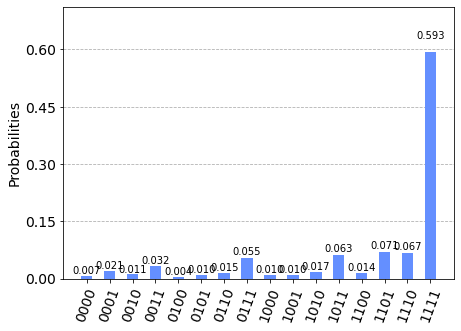

In [207]:
counts = job.result().get_counts()

state = "0"*N 
print("Type :", type_oracle)

plot_histogram(counts)

- You can clearly see that the probability of the $|0\rangle^{\otimes n}$ state is very very low ~ 0
- And our function was **balanced!**
- That's what we expected and that is what experiment showed us!

More info, more qubits: https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html